# Discovery of Writing Differences

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>



## Imports

In [145]:
import pandas as pd
import re
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Exploring Available Books

To start with, figure out which books were not downloaded and yet they are present in the metadata csv!

In [2]:
# list of books downloaded successfully into the /raw/ folder
books_list = []

for name in glob.glob('../data/raw/*'):
    books_list.append(re.findall(r'PG\d*', name)[0])

# the metadata (books that should be there)
library = pd.read_csv('../data/metadata.csv')

# the difference
len(library) - len(books_list)

3435

There are 3435 "books" listed in the metadata that did not get downloaded.

In [3]:
library.loc[~library['id'].isin(books_list)]['type'].value_counts(dropna=False)

NaN            2215
Sound          1104
Dataset          83
Image            33
MovingImage       7
StillImage        3
Collection        1
Text              1
Name: type, dtype: int64

Starting with those that are marked as 'type' being NaN. From my exploration further on, those are actually books. I might have to come back to it at a later date and figure out why those books were not downloaded.

In [4]:
library.loc[(~library['id'].isin(books_list)) & (library['type'].isna())].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
606,PG10547,Topsy-Turvy,"Verne, Jules",1828.0,1905.0,['en'],126,"{'Science fiction, French -- Translations into...",NaN
703,PG10634,"The Queen of Hearts, and Sing a Song for Sixpence","Caldecott, Randolph",1846.0,1886.0,['en'],44,"{'Picture books for children', 'Nursery rhymes...",NaN
841,PG10762,Impressions of Theophrastus Such,"Eliot, George",1819.0,1880.0,['en'],110,"{'Authors -- Fiction', 'England -- Fiction', '...",NaN
923,PG10836,The Algebra of Logic,"Couturat, Louis",1868.0,1914.0,['en'],97,"{'Logic, Symbolic and mathematical', 'Algebrai...",NaN
1106,PG10,The King James Version of the Bible,NaN,NaN,NaN,['en'],5831,{'Bible'},NaN


For 'Sound' I don't care that yhey did not get downloaded -  I'm only looking for books and not for audio files.

In [5]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Sound')].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
151,PG10137,Mary Had a Little Lamb: Recording taken from M...,"Edison, Thomas A. (Thomas Alva)",1847.0,1931.0,['en'],21,"{'Nursery rhymes, American'}",Sound
168,PG10152,Voice Trial - Kinetophone actor audition,"Lett, Bob",NaN,NaN,['en'],4,{'Auditions'},Sound
169,PG10153,Voice Trial - Kinetophone Actor Audition,"Lenord, Frank",NaN,NaN,['en'],4,{'Auditions'},Sound
170,PG10154,Voice Trial - Kinetophone Actor Audition,"Schultz, Siegfried Von",NaN,NaN,['en'],0,{'Auditions'},Sound
171,PG10155,The Right of the People to Rule,"Roosevelt, Theodore",1858.0,1919.0,['en'],9,"{'Progressivism (United States politics)', 'Po...",Sound


Next up, "datasets". It appears the vast majority of them are genomes. There are 10 calculations of square roots and 1/pi to a million digits. And 'Moby Word Lists' is just info on gutenberg, disclaimers, etc...

In [6]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Dataset')].groupby('author')[['id']].count()

,id
author,
"Bonnell, Jerry T.",2
"De Forest, Norman L.",1
Human Genome Project,72
"Kanada, Yasumasa",1
"Kerr, Stan",1
"Nemiroff, Robert J.",5
"Ward, Grady",1


Onto checking out the 'images'! the 'Image' contains music sheets. 'MovingImage' contains comets video, rotating earth and 5 nuclear test videos. 'StillImages' contain a kids story illustrated and two maps/ map images.

In [7]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Image')].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1108,PG11001,String Quartet No. 05 in A major Opus 18,"Beethoven, Ludwig van",1770.0,1827.0,['en'],5,"{'Music', 'String quartets -- Scores'}",Image
1109,PG11002,"String Quartet No. 11 in F minor Opus 95 ""Seri...","Beethoven, Ludwig van",1770.0,1827.0,['en'],6,"{'String quartets -- Scores', 'Music'}",Image
1944,PG11755,String Quartet No. 10 in E flat major Opus 74 ...,"Beethoven, Ludwig van",1770.0,1827.0,['en'],15,"{'Music', 'String quartets -- Scores'}",Image
2381,PG12149,String Quartet No. 03 in D major Opus 18,"Beethoven, Ludwig van",1770.0,1827.0,['en'],15,"{'String quartets -- Scores', 'Music'}",Image
2479,PG12237,String Quartet No. 16 in F major Opus 135,"Beethoven, Ludwig van",1770.0,1827.0,['en'],21,"{'Music', 'String quartets -- Scores'}",Image


In [8]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'StillImage')]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1661,PG114,The Tenniel Illustrations for Carroll's Alice ...,"Tenniel, John",1820.0,1914.0,['en'],391,"{""Children's stories"", 'Fantasy fiction'}",StillImage
15515,PG239,Radar Map of the United States,United States,NaN,NaN,['en'],27,{'United States -- Maps'},StillImage
67797,PG758,"LandSat Picture of Washington, DC",United States. National Aeronautics and Space ...,NaN,NaN,['en'],36,{'Washington (D.C.) -- Remote-sensing images'},StillImage


And finally, Collection contains 'Project Gutenberg DVD: The July 2006 Special' and the only not downloaded text is just empty.

In [9]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Collection')]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
10150,PG19159,Project Gutenberg DVD: The July 2006 Special,NaN,NaN,NaN,['en'],73,set(),Collection


In [10]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Text')]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
69464,PG90907,NaN,NaN,NaN,NaN,['en'],1,set(),Text


In [11]:
# to find specific authors
# library.loc[library['author'].str.find('Lovecraft') > -1]

## Selecting English books

Starting with 70449 "books" in the catalogue, first select all the texts in the library that are marked as being in english ('en').

That reduces the library to 56954 books.

In [12]:
library_en = library.loc[library['language'].str.find('en') > -1]

Further, for right now I'm also going to drop all of the additional files that were not downloaded (that I briefly explored in the previous part):
- NaN 1991
- Sound 1039
- Dataset 83
- Image 33
- MovingImage 7
- StillImage 3
- Collection 1
- Text 1

That additionally reduces the library to 53796 books.

In [13]:
library_en = library_en.loc[library_en['id'].isin(books_list)]

Finally, deleting some files accompanying sound, dataset, etc.. that got downloaded. Only 20 total.

In [14]:
library_en = library_en[library_en['type'].isna()]

Final count of books to potentially use is 53776!

## Beginning Exploration of Authors

There are:
- 6345 books with 10 or less downloads 
- 42617 books with 100 or less downloads

Potentially worth considering!

In [15]:
library_en[library_en['downloads'] <= 10].shape

(6345, 9)

Grouping by author, I noticed that there's 117 titles by "unknown" author, 601 "anonymous" and 3422 "various". Upon further inspection of Various, they are majority "periodicals", meaning various magazines and so I decided it was safe to remove that.

As for unknown and anonymous, those might be interesting to check once I have a model, but as is, since I'm looking for writing style, I do want to know who the author is. (lol at Happy and Gay Marching Away - children's poetry by Unknown author).

In [16]:
library_en.groupby('author')[['title']].count().sort_values(by='title', ascending=False).head(20)

,title
author,
Various,3422
Anonymous,601
"Shakespeare, William",178
"Ebers, Georg",163
"Parker, Gilbert",132
"Oliphant, Mrs. (Margaret)",132
"Kingston, William Henry Giles",132
"Twain, Mark",128
"Fenn, George Manville",128


In [17]:
library_en[library_en['author'] == 'Various']['subjects'].value_counts().head(20)

{'English wit and humor -- Periodicals'}                                                                                            550
{'Periodicals'}                                                                                                                     233
{'Questions and answers -- Periodicals'}                                                                                            220
{'Popular literature -- Great Britain -- Periodicals'}                                                                              195
{"Children's periodicals, American"}                                                                                                162
{'Congregational churches -- Missions -- Periodicals', 'Home missions -- Periodicals'}                                              145
{'Encyclopedias and dictionaries'}                                                                                                  136
{'American periodicals'}                        

Below, keeping authors that are not Anonymous, Unknown or Various, which cuts down to 49636 books.

In [18]:
library_en = library_en[~library_en['author'].isin(['Anonymous', 'Unknown', 'Various'])]

For starters, I'll just look at top 6 authors (based on # of books).

In [19]:
top_six_authors_list = library_en.groupby('author')['title'].count().sort_values(ascending=False).head(6).index.to_list()

In [20]:
library_top_six = library_en[library_en['author'].isin(top_six_authors_list)]

In [76]:
# note: downloads are for the last 30 days
library_en.sort_values(by='downloads', ascending=False).head(20)

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
5702,PG1513,Romeo and Juliet,"Shakespeare, William",1564.0,1616.0,['en'],166112,"{'Juliet (Fictitious character) -- Drama', 'Ro...",NaN
18200,PG2641,A Room with a View,"Forster, E. M. (Edward Morgan)",1879.0,1970.0,['en'],145035,"{'British -- Italy -- Fiction', 'Florence (Ita...",NaN
30065,PG37106,"Little Women; Or, Meg, Jo, Beth, and Amy","Alcott, Louisa May",1832.0,1888.0,['en'],139345,"{'Bildungsromans', 'March family (Fictitious c...",NaN
5102,PG145,Middlemarch,"Eliot, George",1819.0,1880.0,['en'],138208,"{'Bildungsromans', 'Married people -- Fiction'...",NaN
18867,PG2701,"Moby Dick; Or, The Whale","Melville, Herman",1819.0,1891.0,['en'],135040,"{'Whaling -- Fiction', 'Psychological fiction'...",NaN
7089,PG16389,The Enchanted April,"Von Arnim, Elizabeth",1866.0,1941.0,['en'],128625,"{'Italy -- Fiction', 'Female friendship -- Fic...",NaN
64356,PG67979,The Blue Castle: a novel,"Montgomery, L. M. (Lucy Maud)",1874.0,1942.0,['en'],127849,"{'Canada -- History -- 1914-1945 -- Fiction', ...",NaN
110,PG100,The Complete Works of William Shakespeare,"Shakespeare, William",1564.0,1616.0,['en'],124452,{'English drama -- Early modern and Elizabetha...,NaN
32723,PG394,Cranford,"Gaskell, Elizabeth Cleghorn",1810.0,1865.0,['en'],123855,"{'Villages -- Fiction', 'Older women -- Fictio...",NaN
63958,PG6761,The Adventures of Ferdinand Count Fathom — Com...,"Smollett, T. (Tobias)",1721.0,1771.0,['en'],123023,"{'Adventure stories', 'Gothic fiction'}",NaN


## Reading and Tokenizing Books

Function that opens files and extracts the text (leaving the Gutenberg info at top and bottom out).

In [21]:
def import_book(filepath):
    
    try:
        with open(filepath, encoding = 'utf-8') as fi:
            book = fi.read()

    except:
        # note: when using this, the weird characters, such as ì get left out!
        with open(filepath, encoding = 'unicode_escape') as fi:
            book = fi.read()

    if(not re.search('\*\*\* START OF .+? \*\*\*', book)):
        book_start = 0
    else:
        book_start = re.search('\*\*\* START OF .+? \*\*\*', book).end()

    if(not re.search('\*\*\* END OF .+? \*\*\*', book)):
        book_end = -1
    else:
        book_end = re.search('\*\*\* END OF .+? \*\*\*', book).start()

    book = book[book_start : book_end]

    return book

Process the top 6 authors books;

> NOTE: here I found out that some files have strange characters and won't be opened. I wil lhave to decide what to do with those.

In [22]:
for book_id in library_top_six['id']:
    
    filepath = f'../data/raw/{book_id}_raw.txt'

    try:
        book = import_book(filepath)

        library_top_six.loc[library_top_six['id'] == book_id, 'book_content'] = book
        
    except:
        print('could not open', filepath)

        library_top_six.loc[library_top_six['id'] == book_id, 'book_content'] = 'could not open'

    

/var/folders/3t/x8rz35tn765cm0bkf_n4ydlh0000gn/T/ipykernel_61201/4033238918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  library_top_six.loc[library_top_six['id'] == book_id, 'book_content'] = book


In [23]:
# there are some books who had weird characters and were not able to open
library_unopened_books = library_top_six.loc[library_top_six['book_content'] == 'could not open']

library_top_six = library_top_six.loc[library_top_six['book_content'] != 'could not open']

In [83]:
# to see more in a column of df
# pd.set_option('display.max_colwidth', 50) #set it to None to display all

In [25]:
top_six_authors_dict = {top_six_authors_list[i]: i for i in range(6)}

library_top_six = library_top_six.replace({'author': top_six_authors_dict})

In [26]:
top_six_authors_dict

{'Shakespeare, William': 0,
 'Ebers, Georg': 1,
 'Parker, Gilbert': 2,
 'Kingston, William Henry Giles': 3,
 'Oliphant, Mrs. (Margaret)': 4,
 'Twain, Mark': 5}

In [27]:
X = library_top_six[['book_content']]
y = library_top_six['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [71]:
X_train.shape

X_test.shape

(217, 1)

In [28]:
pipe_vect_logreg = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('logreg', LogisticRegression(max_iter = 10000))
    ]
)

In [29]:
pipe_vect_logreg.fit(X_train['book_content'], y_train)
y_pred = pipe_vect_logreg.predict(X_test['book_content'])

print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
print('---- confusion matrix ------')
print(confusion_matrix(y_test, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y_test, y_pred))

accuracy score: 0.9953917050691244 

---- confusion matrix ------
[[45  0  0  0  0  0]
 [ 0 41  0  0  0  0]
 [ 0  0 33  0  0  0]
 [ 0  0  0 33  0  0]
 [ 0  0  0  0 32  1]
 [ 0  0  0  0  0 32]] 

-------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        33
           4       1.00      0.97      0.98        33
           5       0.97      1.00      0.98        32

    accuracy                           1.00       217
   macro avg       0.99      0.99      0.99       217
weighted avg       1.00      1.00      1.00       217



In [30]:
fig = px.imshow(confusion_matrix(y_test, y_pred),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x="Predicted Label",
                            y="True Label"),
                            x=tuple(top_six_authors_dict.keys()),
                            y=tuple(top_six_authors_dict.keys()),
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

In [64]:
#pipe_vect_logreg['vect'].vocabulary_['î']

{k:v for (k,v) in pipe_vect_logreg['vect'].vocabulary_.items() if v < 100}

{'000': 13,
 '000 100': 16,
 '000 000': 15,
 '000 foot': 58,
 '000 horsemen': 71,
 '000 chariots': 44,
 '00': 0,
 '00 99': 2,
 '000 bequest': 32,
 '000 men': 83,
 '00 mr': 7,
 '00 this': 9,
 '00 the': 8,
 '00 it': 6,
 '000 are': 29,
 '00 cloth': 3,
 '00 transcriber': 12,
 '000 by': 39,
 '000 journalist': 79,
 '000 acres': 20,
 '000 it': 78,
 '000 about': 18,
 '000 and': 26,
 '000 feet': 57,
 '000 or': 95,
 '000 daily': 49,
 '000 on': 94,
 '000 at': 30,
 '000 inhabitants': 76,
 '000 however': 72,
 '00 in': 5,
 '000 per': 99,
 '000 dollars': 52,
 '000 miles': 84,
 '00 to': 10,
 '000 in': 74,
 '000 copies': 47,
 '000 of': 92,
 '000 but': 37,
 '000 already': 23,
 '000 for': 59,
 '000 cash': 42,
 '000 people': 98,
 '000 had': 65,
 '000 out': 97,
 '000 now': 90,
 '000 day': 50,
 '000 books': 35,
 '000 month': 85,
 '000 an': 25,
 '000 more': 86,
 '000 is': 77,
 '000 left': 81,
 '000 have': 66,
 '000 odd': 91,
 '000 my': 87,
 '000 children': 45,
 '000 endowment': 55,
 '000 historical': 70,
 '0

To test out my logic, let's see how my own two books measure up!

In [31]:
my_books = pd.DataFrame()

for book_name in ('Deathway', 'Lambda'):
        filepath = f'../data/{book_name} by Tomo Umer.txt'

        with open(filepath, encoding = 'utf-8') as fi:
                book = fi.read()
        
        tmp_book = pd.DataFrame({'title': [book_name], 'book_content': [book]})

        my_books = pd.concat([my_books, tmp_book], ignore_index = True)

In [32]:
pipe_vect_logreg.predict_proba(my_books['book_content'])

array([[0.1034626 , 0.18213029, 0.19663621, 0.10284012, 0.1766654 ,
        0.23826538],
       [0.05357954, 0.16703744, 0.1564819 , 0.15363318, 0.1453018 ,
        0.32396614]])

It would appear both of my books are most similar to Mark Twain!

In [33]:
pd.DataFrame(pipe_vect_logreg.predict_proba(my_books['book_content']),columns=top_six_authors_dict.keys())

,"Shakespeare, William","Ebers, Georg","Parker, Gilbert","Kingston, William Henry Giles","Oliphant, Mrs. (Margaret)","Twain, Mark"
0,0.103463,0.182130,0.196636,0.102840,0.176665,0.238265
1,0.053580,0.167037,0.156482,0.153633,0.145302,0.323966


In [34]:
test_df = pd.DataFrame(pipe_vect_logreg.predict_proba(my_books['book_content']).T, columns=['Deathway', 'Lambda'])

test_df.insert (0, 'Authors', top_six_authors_dict.keys())

test_df

,Authors,Deathway,Lambda
0,"Shakespeare, William",0.103463,0.053580
1,"Ebers, Georg",0.182130,0.167037
2,"Parker, Gilbert",0.196636,0.156482
3,"Kingston, William Henry Giles",0.102840,0.153633
4,"Oliphant, Mrs. (Margaret)",0.176665,0.145302
5,"Twain, Mark",0.238265,0.323966


## Neural Networks

Using neural networks in order to obtain a better representation of similarity (by using an intermediate hidden layer of 100 neurons).

In [77]:
pipe_vect_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, ),
                             #activation = 'tanh',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [78]:
pipe_vect_nn.fit(X_train['book_content'], y_train)
y_pred = pipe_vect_nn.predict(X_test['book_content'])

print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
print('---- confusion matrix ------')
print(confusion_matrix(y_test, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y_test, y_pred))

Iteration 1, loss = 0.58773370
Iteration 2, loss = 0.00268382
Iteration 3, loss = 0.00162671
Iteration 4, loss = 0.00119857
Iteration 5, loss = 0.00118291
Iteration 6, loss = 0.00120331
Iteration 7, loss = 0.00122831
Iteration 8, loss = 0.00125259
Iteration 9, loss = 0.00126799
Iteration 10, loss = 0.00128133
Iteration 11, loss = 0.00128883
Iteration 12, loss = 0.00129311
Iteration 13, loss = 0.00129538
Iteration 14, loss = 0.00129485
Iteration 15, loss = 0.00129274
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
accuracy score: 1.0 

---- confusion matrix ------
[[45  0  0  0  0  0]
 [ 0 41  0  0  0  0]
 [ 0  0 33  0  0  0]
 [ 0  0  0 33  0  0]
 [ 0  0  0  0 33  0]
 [ 0  0  0  0  0 32]] 

-------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        33
 

Now that I have the neural network fit, I need to create an autoencoder with that.

In [146]:
#encoder = MLPClassifier()
encoder = MLPRegressor()
encoder.coefs_ = pipe_vect_nn['nn'].coefs_[:1]
encoder.intercepts_ = pipe_vect_nn['nn'].intercepts_[:1]
encoder.n_layers_ = 2
encoder.out_activation_ = 'relu'

#encoder.n_outputs_ = pipe_vect_nn['nn'].n_outputs_
#encoder._label_binarizer = pipe_vect_nn['nn']._label_binarizer

In [147]:
# copy the pipeline
pipe_vect_encoder = deepcopy(pipe_vect_nn)

# remove the classifier
pipe_vect_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_vect_encoder.steps.append(['enc', encoder])

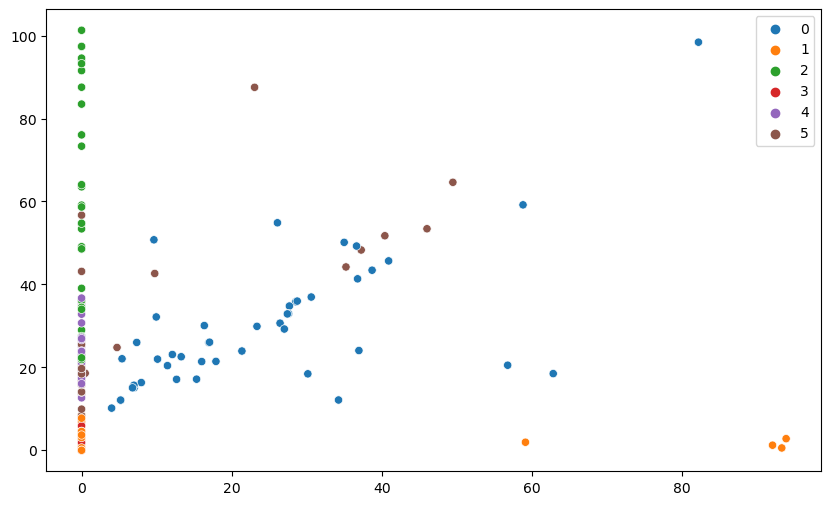

In [151]:
projection = pipe_vect_encoder.predict(X_test['book_content'])

plt.figure(figsize = (10,6))
sns.scatterplot(x=projection[:,0], y=projection[:,1], hue = y_test.astype('category'))
plt.legend(bbox_to_anchor = (1,1));

Now to use the encoder to see how the six authors get represented in this 100-dimensional space.

In [169]:
test_1 = pipe_vect_encoder.predict(library_top_six.loc[library_top_six['author'] == 0]['book_content'])

In [171]:
test_1.shape

(178, 100)

In [170]:
test_2 = pipe_vect_encoder.predict(library_top_six.loc[library_top_six['author'] == 0]['book_content'].str.cat())

ValueError: Iterable over raw text documents expected, string object received.

In [167]:
len(library_top_six.loc[library_top_six['author'] == 0]['book_content'].str.cat())

43036761

In [159]:
top_six_authors_dict

{'Shakespeare, William': 0,
 'Ebers, Georg': 1,
 'Parker, Gilbert': 2,
 'Kingston, William Henry Giles': 3,
 'Oliphant, Mrs. (Margaret)': 4,
 'Twain, Mark': 5}